In [58]:
# Initialize Otter
import otter
grader = otter.Notebook("image_mask_kmeans.ipynb")

# Instructions

This assignment introduces you to a common task (creating a segmentation mask) and a common tool (kmeans) for doing clustering of data and the difference in color spaces.

Slides: https://docs.google.com/presentation/d/1qZ2NbB7Hrqt1rXhr7lI3vzIdlLHq94JU-L_H3ZELJL8/edit?usp=sharing

See the stats assignment for setting up/calling kmeans

In [59]:
# There are no shortage of kmeans implementations out there - using scipy's
import numpy as np
from scipy.cluster.vq import kmeans, vq, whiten
import imageio
from numpy.random import normal, uniform, randint
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv

<!-- BEGIN QUESTION -->

# Run kmeans on multiple images

Note: See slides for what order to *implement* these in - this is the order for the code itself. I highly recommend *against* writing it all and then trying to debug it. Do one bit at a time.

- Step 1: If use_hsv is true, convert the image to hsv (see skimage rgb2hsv - skimage has a ton of these conversion routines)
- Step 2: reshape the data to be an nx3 matrix kmeans assumes each row is a data point. So you have to give it a (widthXheight) X 3 matrix, not the imagedata as-is (WXHX3). See numpy reshape.
- Step 3: Whiten the data
- Step 4: Call kmeans with the whitened data to get out the centers
 Note: kmeans returns a tuple with the centers in the first part and the overall fit in the second
- Step 5: Get the ids out using vq
    -- This also returns a tuple; the ids for each pixel are in the first part
    -- You might find the syntax data[ids == i, 0:3] = rgb_color[i] useful - this gets all the data elements with ids with value i and sets them to the color in rgb_color
- Step 5: Create a mask image, and set the colors by rgb_color[ id for pixel ]
- Step 6: Create a second mask image, setting the color to be the average color of the cluster

Two ways to do this
 -  "undo" the whitening step on the returned cluster (harder)
 -  Calculate the means of the clusters in the original data
    np.mean(data[ids == c])
   
Note: To do the HSV option, get the RGB version to work. Then go back and do the HSV one
- Simplest way to do this: Copy the code you did before and re-do after converting to hsv first
     Don't forget to take the color centers in the *original* image, not the hsv one
     Don't forget to rename your variables

More complicated: Make a function. Most of the code is the same, except for a conversion to hsv at the beginning

In [60]:
def read_and_cluster_image(image_name, use_hsv, n_clusters):
    """ Read in the image, cluster the pixels by color (either rgb or hsv), then
    draw the clusters as an image mask, colored by both a random color and the center
    color of the cluster
    @image_name - name of image in Data
    @use_hsv - use hsv, y/n
    @n_clusters - number of clusters (up to 6)

    # Read in the file
    im_orig = imageio.imread("Data/" + image_name)
    # Make sure you just have rgb (for those images with an alpha channel)
    im_orig = im_orig[:, :, 0:3]

    # The plot to put the images in
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Make name for the image from the input parameters
    str_im_name = image_name.split('.')[0] + " "
    if use_hsv:
        str_im_name += "HSV"
    else:
        str_im_name += "RGB"

    str_im_name += f", k={n_clusters}"

    # This is how you draw an image in a matplotlib figure
    axs[0].imshow(im_orig)
    # This sets the title
    axs[0].set_title(str_im_name)

    # An array of some default color values to use for making the rgb mask image
    rgb_color = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [0, 255, 255], [255, 0, 255]]
    ...
    axs[1].set_title("ID colored by rgb")
    axs[2].set_title("ID colored by cluster average")"""
    try:
        im_orig = imageio.imread("Data/" + image_name)
    except FileNotFoundError:
        im_orig = imageio.imread(image_name)

    im_orig = im_orig[:, :, 0:3]        
    height, width, _ = im_orig.shape

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    str_im_name = image_name.split('.')[0] + " "
    if use_hsv:
        str_im_name += "HSV"
    else:
        str_im_name += "RGB"
    str_im_name += f", k={n_clusters}"

    axs[0].imshow(im_orig)
    axs[0].set_title(str_im_name)
    axs[0].axis("off")

    if use_hsv:

        im_for_kmeans = rgb2hsv(im_orig.astype(np.float32) / 255.0)
    else:
        im_for_kmeans = im_orig.astype(np.float32)

    data = im_for_kmeans.reshape(-1, 3)  

    whitened = whiten(data)
    centers, _ = kmeans(whitened, n_clusters)
    ids, _ = vq(whitened, centers)       

    rgb_color = np.array(
        [[255,   0,   0],   
         [  0, 255,   0],   
         [  0,   0, 255],   
         [255, 255,   0],   
         [  0, 255, 255],   
         [255,   0, 255]], 
        dtype=np.float32
    )

    if n_clusters > rgb_color.shape[0]:
        raise ValueError("n_clusters must be <= 6")

    N = height * width
    mask_by_id_flat = np.zeros((N, 3), dtype=np.float32)
    mask_by_mean_flat = np.zeros((N, 3), dtype=np.float32)

    rgb_data = im_orig.reshape(-1, 3).astype(np.float32)

    for k in range(n_clusters):
        in_cluster = (ids == k)
        if not np.any(in_cluster):
            continue

        mask_by_id_flat[in_cluster] = rgb_color[k]

        mean_color = np.mean(rgb_data[in_cluster], axis=0)
        mask_by_mean_flat[in_cluster] = mean_color

    mask_by_id = mask_by_id_flat.reshape(height, width, 3).astype(im_orig.dtype)
    mask_by_mean = mask_by_mean_flat.reshape(height, width, 3).astype(im_orig.dtype)

    axs[1].imshow(mask_by_id)
    axs[1].set_title("ID colored by rgb")
    axs[1].axis("off")

    axs[2].imshow(mask_by_mean)
    axs[2].set_title("ID colored by cluster average")
    axs[2].axis("off")

    fig.tight_layout()

    return ids.reshape(height, width)



/var/folders/4t/65ytg75s5qsgvs_rp4g2c06m0000gn/T/ipykernel_58926/3930629767.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im_orig = imageio.imread("Data/" + image_name)


array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int32)

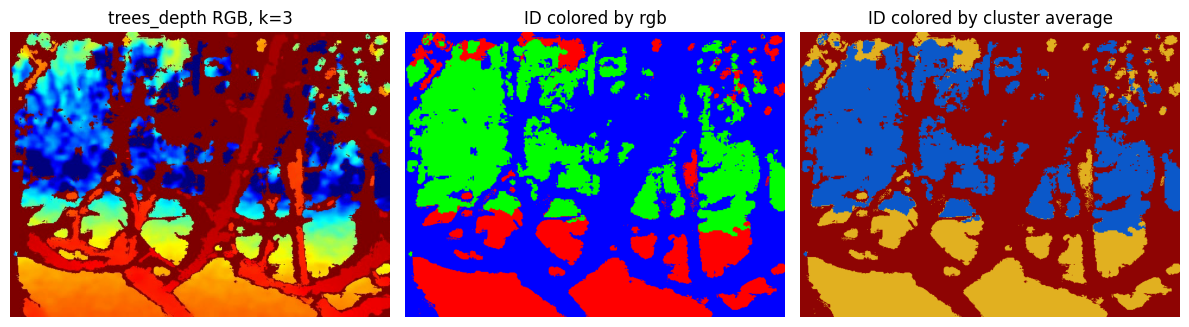

In [61]:
# Test the code with NO hsv transform
read_and_cluster_image("trees_depth.png", use_hsv=False, n_clusters=3)

/var/folders/4t/65ytg75s5qsgvs_rp4g2c06m0000gn/T/ipykernel_58926/3930629767.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im_orig = imageio.imread("Data/" + image_name)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

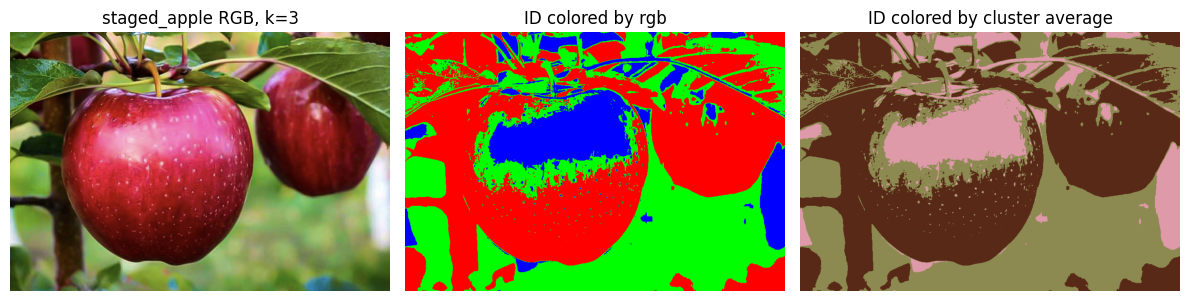

In [62]:
read_and_cluster_image("staged_apple.png", use_hsv=False, n_clusters=3)

/var/folders/4t/65ytg75s5qsgvs_rp4g2c06m0000gn/T/ipykernel_58926/3930629767.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im_orig = imageio.imread("Data/" + image_name)


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

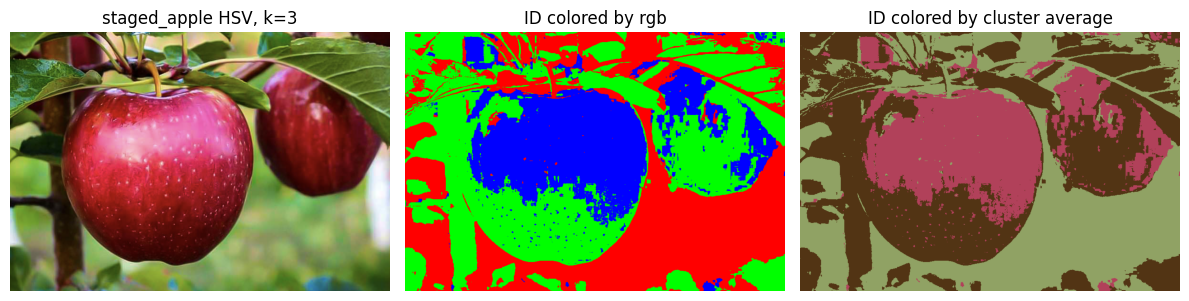

In [63]:
# Compare the above with hsv versus not - note that this throws a warning for me
read_and_cluster_image("staged_apple.png", use_hsv=True, n_clusters=3)

/var/folders/4t/65ytg75s5qsgvs_rp4g2c06m0000gn/T/ipykernel_58926/3930629767.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im_orig = imageio.imread("Data/" + image_name)


array([[0, 0, 0, ..., 3, 3, 1],
       [0, 0, 0, ..., 3, 3, 1],
       [0, 0, 0, ..., 3, 3, 1],
       ...,
       [2, 3, 2, ..., 1, 1, 1],
       [2, 3, 2, ..., 1, 1, 1],
       [2, 3, 2, ..., 1, 1, 3]], dtype=int32)

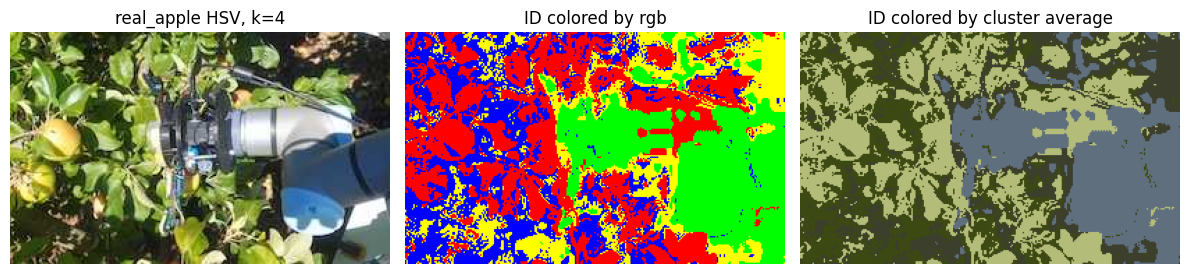

In [64]:
read_and_cluster_image("real_apple.jpg", True, 4)

/var/folders/4t/65ytg75s5qsgvs_rp4g2c06m0000gn/T/ipykernel_58926/3930629767.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im_orig = imageio.imread("Data/" + image_name)


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int32)

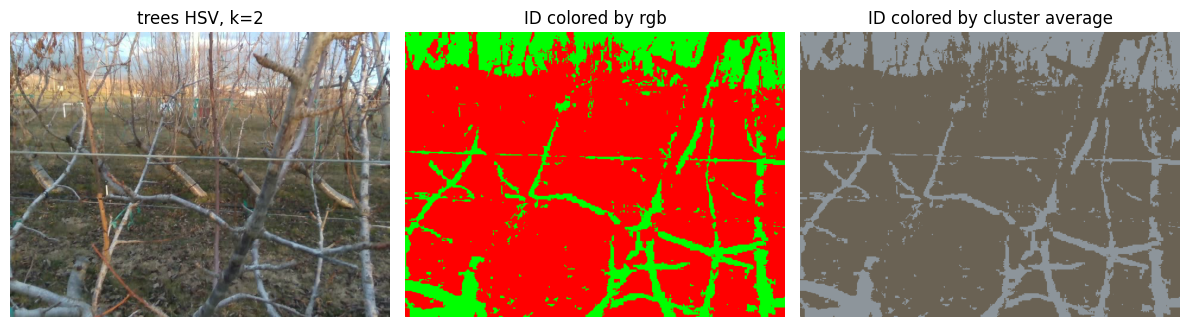

In [65]:
read_and_cluster_image("trees.png", True, 2)

<!-- END QUESTION -->

## Hours and collaborators
Required for every assignment - fill out before you hand-in.

Listing names and websites helps you to document who you worked with and what internet help you received in the case of any plagiarism issues. You should list names of anyone (in class or not) who has substantially helped you with an assignment - or anyone you have *helped*. You do not need to list TAs.

Listing hours helps us track if the assignments are too long.

In [66]:

# List of names (creates a set)
worked_with_names = {"self"}
# List of URLS FW25(creates a set)
websites = {"coursera.org, udemy.com, chatgpt for some concepts and errors"}
# Approximate number of hours, including lab/in-class time
hours = 12

In [67]:
grader.check("hours_collaborators")

hours_collaborators results: All test cases passed!

### To submit

- Do a restart then run all to make sure everything runs ok
- Save the file
- Submit this .ipynb file to Gradescope 
- You do NOT need to submit the data files - we will supply those
- Take out/suppress all print statements

If the Gradescope autograder fails, please check here first for common reasons for it to fail
    https://docs.google.com/presentation/d/1tYa5oycUiG4YhXUq5vHvPOpWJ4k_xUPp2rUNIL7Q9RI/edit?usp=sharing

Most likely failure for this assignment is not naming the data directory and files correctly; capitalization matters for the Gradescope grader. 

Second most likely failure is because your code ran very, very slowly and the autograder timed out.
